# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [30]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 60000 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (60000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [31]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [32]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [33]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(54458, 10)

In [34]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

90.76333333333334

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [35]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [36]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [37]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(54456, 10)


1    45572
0     8884
Name: Score, dtype: int64

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [38]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;
final.shape

2
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


(54456, 10)

In [39]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))
final.shape

{'then', 'did', 'nor', 'these', 'most', "shan't", 'so', 'themselves', 'aren', 'doesn', 'mustn', "you'll", 'more', 'theirs', "you're", 'they', 'than', 'only', "mightn't", 'your', 'after', 'now', 'her', 'them', 'hasn', "she's", 'was', 'am', 'herself', 'be', 'and', 'our', 'myself', 'why', 'him', 'hadn', 'it', "shouldn't", 'didn', 'are', 'again', 'me', 'won', "you'd", 'there', 'that', 'ma', 'wouldn', 'an', 'to', 'ain', 'at', 'his', 'of', 'while', 'for', 'wasn', 'doing', 'against', 'the', 'about', 'm', 'with', 'all', 'you', 'itself', "isn't", 'do', 'is', 'we', 'when', 'any', 'being', "you've", "wouldn't", 'haven', 'over', 'whom', 'up', 'or', 'should', 'ours', 'under', 'i', 'y', 'few', 'before', 'couldn', 'but', 'each', 'my', 'their', 'until', 'yourself', 'she', 'below', "weren't", 'through', 'who', 'some', 'such', 'how', 'were', 'further', 'here', 'ourselves', 'can', 'from', 'above', "aren't", 'don', 'as', 'shan', 'weren', 'needn', 'its', 'own', 'd', 'both', 'have', 'in', 'himself', 'this',

(54456, 10)

In [40]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final4.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final4.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)
print(final.shape)

(54456, 10)


In [58]:
if os.path.isfile('final4.sqlite'):
    conn = sqlite3.connect('final4.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")
print(final.shape)
print(final['Score'].value_counts())

(54456, 12)
1    45572
0     8884
Name: Score, dtype: int64


# [7.2.2] Bag of Words (BoW)

In [4]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
print(final.shape)
final_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])
final_counts

(54456, 12)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (54456, 27154)
the number of unique words  27154


<54456x27154 sparse matrix of type '<class 'numpy.int64'>'
	with 1716934 stored elements in Compressed Sparse Row format>

# KNN for Bag of Words using brute force

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(final_counts, final['Score'], test_size=0.2)
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,test_size=0.2)

In [6]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import f1_score
k = []
pred_cv = []
for i in range(1,20,2):
    knn =KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    prediction = knn.predict(x_cv)
    score = accuracy_score(y_cv,prediction)
    print(i," ------> ",score)
    pred_cv.append(score)
    k.append(i)

1  ------>  0.8086766900034431
3  ------>  0.8348444852519225
5  ------>  0.8424193733501664
7  ------>  0.8462068173992884
9  ------>  0.8456329622403306
11  ------>  0.8452886491449558
13  ------>  0.8446000229542063
15  ------>  0.8435670836680822
17  ------>  0.8427636864455411
19  ------>  0.8423046023183749


(34851, 27154)
(10892, 27154)
(8713, 27154)


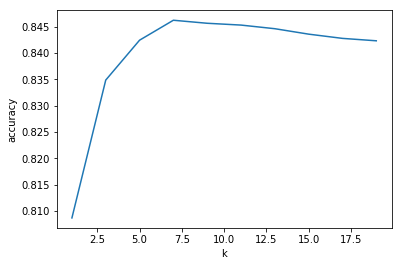

In [7]:
print(x_train.shape)
print(x_test.shape)
print(x_cv.shape)
plt.plot(k,pred_cv)
plt.xlabel("k")
plt.ylabel("accuracy")
plt.show()

-> From the above plot we can see that we are getting the maximum accuracy at k = 7

# calculating the train error of the model

accuracy score 0.8586267252015725
macro f1 score for training data : 0.596916651848169
micro f1 scoore for training data: 0.8586267252015725
hamming loss for training data: 0.1413732747984276
Precision recall report for training data:
               precision    recall  f1-score   support

           0       0.85      0.16      0.27      5687
           1       0.86      0.99      0.92     29164

   micro avg       0.86      0.86      0.86     34851
   macro avg       0.86      0.58      0.60     34851
weighted avg       0.86      0.86      0.82     34851



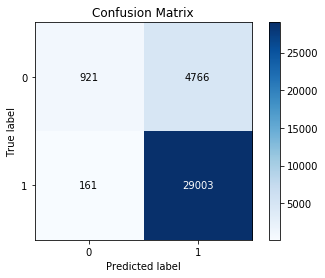

In [8]:
import scikitplot.metrics as skplt
knn =KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train,y_train)
prediction = knn.predict(x_train)
print("accuracy score",accuracy_score(y_train,prediction))
skplt.plot_confusion_matrix(y_train,prediction)
print("macro f1 score for training data :",metrics.f1_score(y_train, prediction, average = 'macro'))
print("micro f1 scoore for training data:",metrics.f1_score(y_train, prediction, average = 'micro'))
print("hamming loss for training data:",metrics.hamming_loss(y_train,prediction))
print("Precision recall report for training data:\n",metrics.classification_report(y_train, prediction))

-> from the above result we can conclude various results-:
1. The training accuracy of our model is .8586
2. There were total 5687 negative reviews in my training data in which 921 were correctly classified by my algo where as rest of the point were miss classified by my algo
3. There were total  29164 positive points in my training data in which 29003 were correctly classified and rest of the 161 points were missclassified by my algorithm

# KNN Over the unseen data or test data 

accuracy score 0.8402497245684907
macro f1 score : 0.5286364578761154
micro f1 scoore : 0.8402497245684907
hamming loss : 0.15975027543150935
Precision recall report :
               precision    recall  f1-score   support

           0       0.62      0.08      0.15      1799
           1       0.85      0.99      0.91      9093

   micro avg       0.84      0.84      0.84     10892
   macro avg       0.73      0.54      0.53     10892
weighted avg       0.81      0.84      0.79     10892



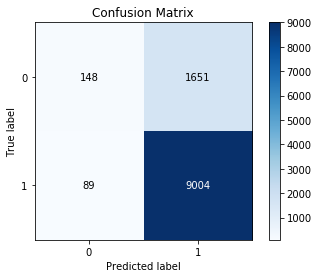

In [9]:
# as i have already train my model using k = 9 so need not to train again i can ue it directly
prediction = knn.predict(x_test)
print("accuracy score",accuracy_score(y_test,prediction))
skplt.plot_confusion_matrix(y_test,prediction)
print("macro f1 score :",metrics.f1_score(y_test, prediction, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, prediction, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,prediction))
print("Precision recall report :\n",metrics.classification_report(y_test, prediction))

# KNN on Bag of Words using kd tree over bag of words
-> calculating the training error 

accuracy score using kd tree 0.869300737425038
macro f1 score : 0.685590241195846
micro f1 scoore : 0.869300737425038
hamming loss : 0.13069926257496198
Precision recall report :
               precision    recall  f1-score   support

           0       0.72      0.32      0.45      5687
           1       0.88      0.98      0.93     29164

   micro avg       0.87      0.87      0.87     34851
   macro avg       0.80      0.65      0.69     34851
weighted avg       0.86      0.87      0.85     34851



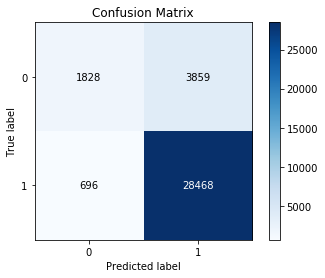

In [10]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=100)
x = tsvd.fit_transform(x_train) # conversion into dence matrix
xt = tsvd.fit_transform(x_test)
knn = KNeighborsClassifier(n_neighbors = 7,algorithm = 'kd_tree')
knn.fit(x,y_train)
prediction = knn.predict(x)
print("accuracy score using kd tree",accuracy_score(y_train,prediction))
skplt.plot_confusion_matrix(y_train,prediction)
print("macro f1 score :",metrics.f1_score(y_train, prediction, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_train, prediction, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_train,prediction))
print("Precision recall report :\n",metrics.classification_report(y_train, prediction))

-> From the above result we can conclude the following points -:
1. We are getting higher accuracy when we are using kd_tree as our algorithm in KNN as  compare to brute force.
2. The accuracy of the model on the training data is almost 87%.
3. Other score of the model like micro f1_score is also imporved as compare to the brute force method.
# Testing of the model over the unseen data or test data

accuracy score using kd tree 0.7864487697392581
macro f1 score : 0.5000251025573665
micro f1 scoore : 0.7864487697392581
hamming loss : 0.21355123026074183
Precision recall report :
               precision    recall  f1-score   support

           0       0.19      0.09      0.12      1799
           1       0.84      0.92      0.88      9093

   micro avg       0.79      0.79      0.79     10892
   macro avg       0.51      0.51      0.50     10892
weighted avg       0.73      0.79      0.75     10892



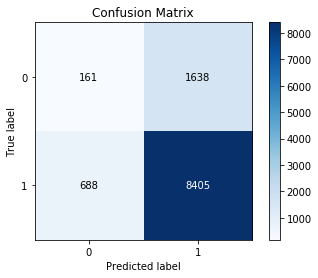

In [11]:
#tsvd = TruncatedSVD(n_components=100)
#x = tsvd.fit_transform(x_train) # conversion into dence matrix
#xt = tsvd.fit_transform(x_test)
#knn = KNeighborsClassifier(n_neighbors = 7,algorithm = 'kd_tree')
#knn.fit(x,y_train)
prediction = knn.predict(xt)
print("accuracy score using kd tree",accuracy_score(y_test,prediction))
skplt.plot_confusion_matrix(y_test,prediction)
print("macro f1 score :",metrics.f1_score(y_test, prediction, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, prediction, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,prediction))
print("Precision recall report :\n",metrics.classification_report(y_test, prediction))

-> from the above result we can say that the accuracy of our KNN model is 78.64%, that is less then our brute force mehtod.

## [7.2.4] Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [12]:
with open('positive_words.pkl', 'rb') as f:
    all_positive_words = pickle.load(f)
with open('negitive_words.pkl', 'rb') as f:
    all_negative_words = pickle.load(f)
    
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 21329), (b'tast', 18897), (b'good', 17053), (b'flavor', 16429), (b'love', 16415), (b'great', 15454), (b'one', 14595), (b'use', 14023), (b'tea', 13054), (b'tri', 13041), (b'product', 12928), (b'coffe', 12312), (b'get', 11022), (b'food', 11002), (b'make', 10810), (b'dog', 8833), (b'would', 8461), (b'eat', 8133), (b'time', 8115), (b'buy', 8032)]
Most Common Negative Words :  [(b'tast', 5558), (b'like', 5293), (b'product', 4228), (b'one', 3219), (b'flavor', 3028), (b'would', 2886), (b'tri', 2839), (b'good', 2367), (b'use', 2360), (b'coffe', 2258), (b'get', 2210), (b'food', 2187), (b'buy', 2133), (b'tea', 2024), (b'dont', 1939), (b'dog', 1871), (b'order', 1868), (b'even', 1812), (b'eat', 1686), (b'box', 1665)]


<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [13]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (54456, 804732)
the number of unique words including both unigrams and bigrams  804732


1 accuracy 0.47423390336279125
3 accuracy 0.6720991621714679
5 accuracy 0.7817054975324228
7 accuracy 0.8120050499253988
9 accuracy 0.8280729943762194
11 accuracy 0.8333524618386319
13 accuracy 0.8353035693790887
15 accuracy 0.8359921955698382
17 accuracy 0.8351887983472971
19 accuracy 0.8358774245380466


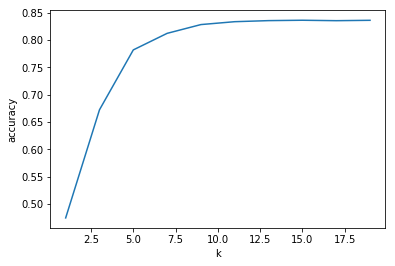

In [14]:
x_train, x_test, y_train, y_test = train_test_split(final_bigram_counts, final['Score'], test_size=0.2)
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,test_size=0.2)
k = []
acc = []
for i in range(1,20,2):
    knn = KNeighborsClassifier(i)
    knn.fit(x_train,y_train)
    prediction = knn.predict(x_cv)
    accuracy = accuracy_score(y_cv,prediction)
    print(i,"accuracy",accuracy)
    k.append(i)
    acc.append(accuracy)
plt.plot(k,acc)
plt.xlabel("k")
plt.ylabel("accuracy")
plt.show()

->In the above code we are getting higher accuracy at k = 15 during the cross vaildation but we will use k = 10 as our   nearest neighbors as our training and cv data consists more positive points so it is giving higher accuracy at large k.
-> Accuracy at k =10 and k =15 is almost same
# Accuracy on the training data using brute force

accuracy score using kd tree 0.8553269633582967
macro f1 score : 0.6299151233365332
micro f1 scoore : 0.8553269633582967
hamming loss : 0.14467303664170325
Precision recall report :
               precision    recall  f1-score   support

           0       0.65      0.23      0.34      5657
           1       0.87      0.98      0.92     29194

   micro avg       0.86      0.86      0.86     34851
   macro avg       0.76      0.60      0.63     34851
weighted avg       0.83      0.86      0.82     34851



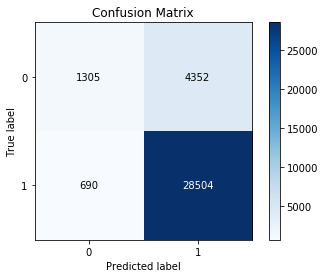

In [15]:
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(x_train,y_train)
prediction = knn.predict(x_train)
print("accuracy score using",accuracy_score(y_train,prediction))
skplt.plot_confusion_matrix(y_train,prediction)
print("macro f1 score :",metrics.f1_score(y_train, prediction, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_train, prediction, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_train,prediction))
print("Precision recall report :\n",metrics.classification_report(y_train, prediction))

# Testing of the model using unseen data or test data

accuracy score using test data 0.8228975394785163
macro f1 score : 0.5316886580627465
micro f1 scoore : 0.8228975394785164
hamming loss : 0.17710246052148365
Precision recall report :
               precision    recall  f1-score   support

           0       0.36      0.10      0.16      1790
           1       0.85      0.96      0.90      9102

   micro avg       0.82      0.82      0.82     10892
   macro avg       0.61      0.53      0.53     10892
weighted avg       0.77      0.82      0.78     10892



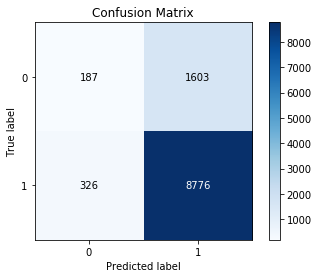

In [16]:
# as for k =10 we have already trained our model so we need not to trained the model again
prediction = knn.predict(x_test)
print("accuracy score using test data",accuracy_score(y_test,prediction))
skplt.plot_confusion_matrix(y_test,prediction)
print("macro f1 score :",metrics.f1_score(y_test, prediction, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, prediction, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,prediction))
print("Precision recall report :\n",metrics.classification_report(y_test, prediction))

-> From the above result we can say that using k =10 our KNN model is giving an accuracy of 82.28% on the unseen data.

# [7.2.5] TF-IDF

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import f1_score
import scikitplot.metrics as skplt
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

In [4]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (54456, 804732)
the number of unique words including both unigrams and bigrams  804732


In [7]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[100000:100010])

some sample features(unique words in the corpus) ['call flour', 'call flower', 'call folk', 'call food', 'call formula', 'call fraud', 'call free', 'call french', 'call fresh', 'call friend']


In [8]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)
final_tf_idf.shape

(54456, 804732)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(final_tf_idf, final['Score'], test_size=0.2)
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,test_size=0.2)

2 accuracy 0.7710317915758063
4 accuracy 0.8429932285091243
6 accuracy 0.8597497991506944
8 accuracy 0.8628486170090669
10 accuracy 0.8638815562951911
12 accuracy 0.8646849535177321
14 accuracy 0.8662917479628142
16 accuracy 0.8649144955813153


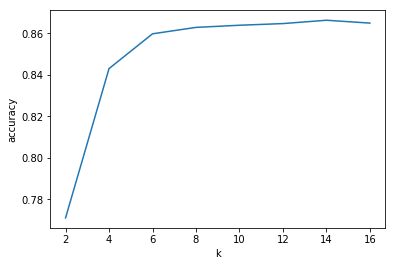

In [11]:
k = []
acc = []
for i in range(2,18,2):
    knn = KNeighborsClassifier(i)
    knn.fit(x_train,y_train)
    prediction = knn.predict(x_cv)
    accuracy = accuracy_score(y_cv,prediction)
    print(i,"accuracy",accuracy)
    k.append(i)
    acc.append(accuracy)
plt.plot(k,acc)
plt.xlabel("k")
plt.ylabel("accuracy")
plt.show()

-> from the above graph we can see that we are getting the highest accuracy at k =14
-> so we will use k = 14 in our model
# Accuracy using the training data

accuracy score : 0.870448480674873
macro f1 score : 0.6589818736683539
micro f1 scoore : 0.8704484806748731
hamming loss : 0.12955151932512696
Precision recall report :
               precision    recall  f1-score   support

           0       0.84      0.25      0.39      5690
           1       0.87      0.99      0.93     29161

   micro avg       0.87      0.87      0.87     34851
   macro avg       0.86      0.62      0.66     34851
weighted avg       0.87      0.87      0.84     34851



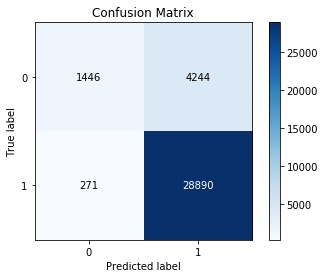

In [12]:
knn = KNeighborsClassifier(n_neighbors = 14)
knn.fit(x_train,y_train)
prediction = knn.predict(x_train)
print("accuracy score :",accuracy_score(y_train,prediction))
skplt.plot_confusion_matrix(y_train,prediction)
print("macro f1 score :",metrics.f1_score(y_train, prediction, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_train, prediction, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_train,prediction))
print("Precision recall report :\n",metrics.classification_report(y_train, prediction))

-> We are getting a accuracy of 87% on the traiining data.
# accuracy of the model on the unseen data i.e. test data

accuracy score : 0.8548475945648182
macro f1 score : 0.6111013360912665
micro f1 scoore : 0.8548475945648182
hamming loss : 0.1451524054351818
Precision recall report :
               precision    recall  f1-score   support

           0       0.79      0.19      0.30      1831
           1       0.86      0.99      0.92      9061

   micro avg       0.85      0.85      0.85     10892
   macro avg       0.82      0.59      0.61     10892
weighted avg       0.85      0.85      0.82     10892



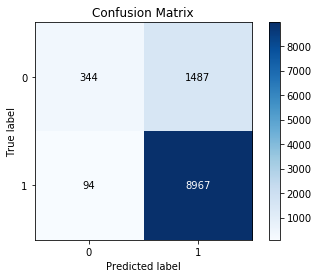

In [13]:
# as we have trained our model on train data so need not to again train it
prediction = knn.predict(x_test)
print("accuracy score :",accuracy_score(y_test,prediction))
skplt.plot_confusion_matrix(y_test,prediction)
print("macro f1 score :",metrics.f1_score(y_test, prediction, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, prediction, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,prediction))
print("Precision recall report :\n",metrics.classification_report(y_test, prediction))

-> From the above result we can see that our model is giving an accuracy of almost 86% on the unseen data that is fairly good.

# KNN on tfidf using the kdtree k = 14

accuracy score using kd tree 0.824825560044069
macro f1 score : 0.46710098762271435
micro f1 scoore : 0.824825560044069
hamming loss : 0.17517443995593096
Precision recall report :
               precision    recall  f1-score   support

           0       0.29      0.02      0.03      1865
           1       0.83      0.99      0.90      9027

   micro avg       0.82      0.82      0.82     10892
   macro avg       0.56      0.50      0.47     10892
weighted avg       0.74      0.82      0.75     10892



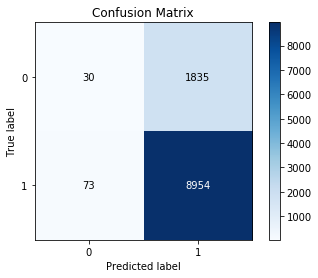

In [6]:
#for n_component > 2 model is giving memory as my system is having only 4GB of RAM
# we can use n_component> 2 if we have higher RAM
tsvd = TruncatedSVD(n_components=2)
x = tsvd.fit_transform(x_train) # conversion into dence matrix
xt = tsvd.fit_transform(x_test)
knn = KNeighborsClassifier(n_neighbors = 14,algorithm ='kd_tree')
knn.fit(x,y_train)
prediction = knn.predict(xt)
print("accuracy score using kd tree",accuracy_score(y_test,prediction))
skplt.plot_confusion_matrix(y_test,prediction)
print("macro f1 score :",metrics.f1_score(y_test, prediction, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, prediction, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,prediction))
print("Precision recall report :\n",metrics.classification_report(y_test, prediction))

# [7.2.6] Word2Vec

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need
is_your_ram_gt_16g=False
want_to_read_sub_set_of_google_w2v = True
want_to_read_whole_google_w2v = True
if not is_your_ram_gt_16g:
    if want_to_read_sub_set_of_google_w2v and  os.path.isfile('google_w2v_for_amazon.pkl'):
        with open('google_w2v_for_amazon.pkl', 'rb') as f:
            # model is dict object, you can directly access any word vector using model[word]
            model = pickle.load(f)
else:
    if want_to_read_whole_google_w2v and os.path.isfile('GoogleNews-vectors-negative300.bin'):
        model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# print("the vector representation of word 'computer'",model.wv['computer'])
# print("the similarity between the words 'woman' and 'man'",model.wv.similarity('woman', 'man'))
# print("the most similar words to the word 'woman'",model.wv.most_similar('woman'))
# this will raise an error
# model.wv.most_similar('tasti')  # "tasti" is the stemmed word for tasty, tastful

In [45]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [46]:
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

dog love saw pet store tag attach regard made china satisfi safe
*****************************************************************
['dog', 'love', 'saw', 'pet', 'store', 'tag', 'attach', 'regard', 'made', 'china', 'satisfi', 'safe']


In [47]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [48]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9400
sample words  ['dog', 'love', 'saw', 'pet', 'store', 'tag', 'attach', 'regard', 'made', 'china', 'satisfi', 'safe', 'chicken', 'product', 'wont', 'buy', 'anymor', 'hard', 'find', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chanc', 'till', 'know', 'go', 'import', 'avail', 'www', 'amazon', 'com', 'victor', 'trap', 'unreal', 'cours', 'total', 'fli', 'pretti', 'stinki', 'right', 'nearbi', 'use', 'bait', 'season', 'cant', 'beat', 'great']


In [49]:
w2v_model.wv.most_similar('tasti')

[('satisfi', 0.7783984541893005),
 ('yummi', 0.7621326446533203),
 ('delici', 0.7506585121154785),
 ('terrif', 0.692543089389801),
 ('hearti', 0.6851441860198975),
 ('good', 0.6549248695373535),
 ('crisp', 0.6514237523078918),
 ('nutriti', 0.6437604427337646),
 ('crispi', 0.633855402469635),
 ('crunch', 0.6213269233703613)]

In [50]:
w2v_model.wv.most_similar('like')

[('dislik', 0.7044693231582642),
 ('appeal', 0.7019355297088623),
 ('prefer', 0.6757634282112122),
 ('weird', 0.6495038270950317),
 ('okay', 0.6194660663604736),
 ('think', 0.6158872842788696),
 ('hate', 0.61036217212677),
 ('good', 0.5908195376396179),
 ('gross', 0.5828086733818054),
 ('enjoy', 0.5772559642791748)]

# [7.2.7] Avg W2V, TFIDF-W2V

In [51]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 54456/54456 [04:55<00:00, 184.22it/s]

54456
50


# devide the data in train, test, and cross_validation

2  ------>  0.7971995868242856
4  ------>  0.8569952943876965
6  ------>  0.8745552622518077
8  ------>  0.8778836221737634
10  ------>  0.8777688511419718
12  ------>  0.8786870193963043
14  ------>  0.8806381269367611
16  ------>  0.8775393090783886


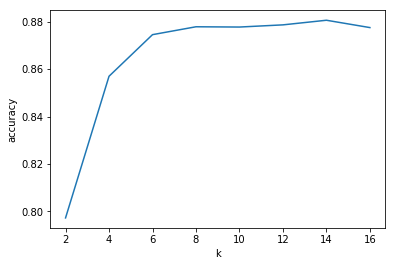

In [14]:
#split the data into train and test and cross validation
# test - 20%
# cv = 20%
# train = 60%
x_train, x_test, y_train, y_test = train_test_split(sent_vectors, final['Score'], test_size=0.2)
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,test_size=0.2)
acc = []
k = []
for i in range(2,18,2):
    knn =KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    prediction = knn.predict(x_cv)
    accuracy = accuracy_score(y_cv,prediction)
    print(i," ------> ",accuracy)
    k.append(i)
    acc.append(accuracy)
plt.plot(k,acc)
plt.xlabel("k")
plt.ylabel("accuracy")
plt.show()

-> We are getting a accuracy of 88% for  k = 14 so we will train our model final model for k =14

# KNN using brute force using avg-w2v over unseen data

accuracy score : 0.8726588321704003
macro f1 score : 0.7125450025966118
micro f1 scoore : 0.8726588321704003
hamming loss : 0.1273411678295997
Precision recall report :
               precision    recall  f1-score   support

           0       0.73      0.38      0.50      1818
           1       0.89      0.97      0.93      9074

   micro avg       0.87      0.87      0.87     10892
   macro avg       0.81      0.68      0.71     10892
weighted avg       0.86      0.87      0.86     10892



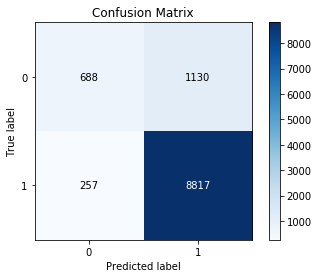

In [15]:
knn = KNeighborsClassifier(n_neighbors = 14)
knn.fit(x_train,y_train)
prediction = knn.predict(x_test)
print("accuracy score :",accuracy_score(y_test,prediction))
skplt.plot_confusion_matrix(y_test,prediction)
print("macro f1 score :",metrics.f1_score(y_test, prediction, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, prediction, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,prediction))
print("Precision recall report :\n",metrics.classification_report(y_test, prediction))

-> So our model is giving an accuracy_score of 87.26% using brute force method of k = 14 that is fairly good.
# KNN over avg-w2v using kd_tree

accuracy score using kd tree 0.793334557473375
macro f1 score : 0.4462929206460728
micro f1 scoore : 0.7933345574733749
hamming loss : 0.20666544252662505
Precision recall report :
               precision    recall  f1-score   support

           0       0.02      0.00      0.01      1818
           1       0.83      0.95      0.88      9074

   micro avg       0.79      0.79      0.79     10892
   macro avg       0.42      0.48      0.45     10892
weighted avg       0.69      0.79      0.74     10892



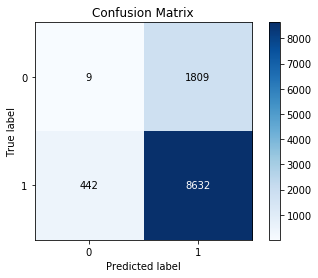

In [20]:
#as RAM of my system is less so i can not run this code for higher value of the n_component
tsvd = TruncatedSVD(n_components=20)
x = tsvd.fit_transform(x_train) # conversion into dence matrix
xt = tsvd.fit_transform(x_test)
knn = KNeighborsClassifier(n_neighbors = 14,algorithm ='kd_tree')
knn.fit(x,y_train)
prediction = knn.predict(xt)
print("accuracy score using kd tree",accuracy_score(y_test,prediction))
skplt.plot_confusion_matrix(y_test,prediction)
print("macro f1 score :",metrics.f1_score(y_test, prediction, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, prediction, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,prediction))
print("Precision recall report :\n",metrics.classification_report(y_test, prediction))

In [52]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted w2v

In [53]:
# TF-IDF weighted Word2Vec
#tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 54456/54456 [04:35<00:00, 197.42it/s]


# Devide the data into train,test, cross_validation

2  ------>  0.7681625157810169
4  ------>  0.834959256283714
6  ------>  0.8527487662114083
8  ------>  0.8591759439917365
10  ------>  0.861471364627568
12  ------>  0.8623895328819006
14  ------>  0.8605531963732354
16  ------>  0.8612418225639848


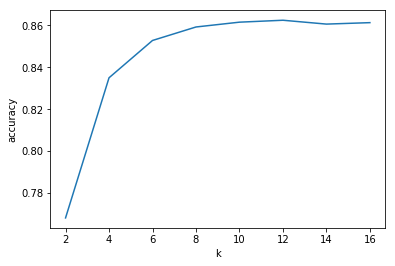

In [54]:
#split the data into train and test and cross validation
# test - 20%
# cv = 20%
# train = 60%
x_train, x_test, y_train, y_test = train_test_split(tfidf_sent_vectors, final['Score'], test_size=0.2)
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,test_size=0.2)
acc = []
k = []
# cross validation to find the best k
for i in range(2,18,2):
    knn =KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    prediction = knn.predict(x_cv)
    accuracy = accuracy_score(y_cv,prediction)
    print(i," ------> ",accuracy)
    k.append(i)
    acc.append(accuracy)
plt.plot(k,acc)
plt.xlabel("k")
plt.ylabel("accuracy")
plt.show()

-> As we can see that at k = 14 we are getting maximum accuracy so we will use k=14 to train our model

# KNN over tfidf w2v using brute force

accuracy score : 0.8668747704737422
macro f1 score : 0.6839921222730029
micro f1 scoore : 0.8668747704737422
hamming loss : 0.1331252295262578
Precision recall report :
               precision    recall  f1-score   support

           0       0.65      0.34      0.44      1721
           1       0.89      0.97      0.92      9171

   micro avg       0.87      0.87      0.87     10892
   macro avg       0.77      0.65      0.68     10892
weighted avg       0.85      0.87      0.85     10892



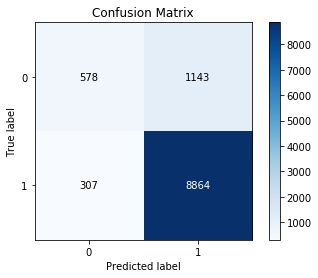

In [56]:
knn = KNeighborsClassifier(n_neighbors = 12)
knn.fit(x_train,y_train)
prediction = knn.predict(x_test)
print("accuracy score :",accuracy_score(y_test,prediction))
skplt.plot_confusion_matrix(y_test,prediction)
print("macro f1 score :",metrics.f1_score(y_test, prediction, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, prediction, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,prediction))
print("Precision recall report :\n",metrics.classification_report(y_test, prediction))

-> In the above model we are getting an accuracy of almost 87%. Rest of the parameter are also fairly good.
# KNN over tfidf w2v using kd_tree

accuracy score using kd tree 0.8410760190965847
macro f1 score : 0.5797579404388876
micro f1 scoore : 0.8410760190965847
hamming loss : 0.15892398090341536
Precision recall report :
               precision    recall  f1-score   support

           0       0.49      0.17      0.25      1721
           1       0.86      0.97      0.91      9171

   micro avg       0.84      0.84      0.84     10892
   macro avg       0.68      0.57      0.58     10892
weighted avg       0.80      0.84      0.81     10892



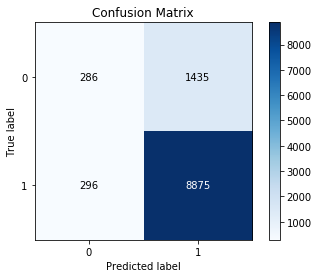

In [57]:
tsvd = TruncatedSVD(n_components=10)
x = tsvd.fit_transform(x_train) # conversion into dence matrix
xt = tsvd.fit_transform(x_test)
knn = KNeighborsClassifier(n_neighbors = 12,algorithm ='kd_tree')
knn.fit(x,y_train)
prediction = knn.predict(xt)
print("accuracy score using kd tree",accuracy_score(y_test,prediction))
skplt.plot_confusion_matrix(y_test,prediction)
print("macro f1 score :",metrics.f1_score(y_test, prediction, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, prediction, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,prediction))
print("Precision recall report :\n",metrics.classification_report(y_test, prediction))

Conclusion-: 
1. We execute our knn over BOW, tfidf, avg w2v, tfidf w2v.
2. For each model we found out the best k using cross validation, as k is hypermeter in KNN.
3. In each model we devide the data in train,test,cv in 60:20:20 ratio
4. Among all the model best accuracy was given by tfidf w2v using brute force for k = 12, various parameter for it are given blow -:
accuracy score : 0.8668747704737422
macro f1 score : 0.6839921222730029
micro f1 scoore : 0.8668747704737422
hamming loss : 0.1331252295262578
